#### Import Data and Libraries

In [1]:
import swarms
import matplotlib.pyplot as plt
import pandas as pd
import pread as pr
from numpy import linspace, pi, array

In [2]:
Mdwarfs = pd.read_csv("../GPIMdwarfs.csv", index_col=0)

In [3]:
"""Access times with data.ages in years
          radii with data.radii in meters
          luminosity with data.lumin in watts
First entry is the root directory.
Second entry is the subdirectory.
Third entry is the filename.
"""
def data_read(mass):
    data = pr.Pread('data', 'Z002', 'pltlum_M'+str(mass)+'Z002.csv') 
    return data

#### Initial Parameters

In [4]:
AU = 1.496e11
pc = 3.086e16
Msun = 1.989e30
Lsun = 3.828e26
Mmoon = 7.35e22
Mearth = 5.972e24

RHO=1500 
eta = 0.4; Nstr = 6.; Dt = 100.; Dmax = 150000.; R_pl = 6.9911e7
lamb = 1.65e-6

time = linspace(1.1e7, 1e8, 500)
#M_jup = [20, 100, 318, 636]
M0 = 10 * Mmoon

In [5]:
star = Mdwarfs.iloc[9] # could do for i in range(24): star = Mdwarfs.iloc[i]

M_s = star['Mass'] * Msun
L_s = star['Lum'] * Lsun
T_star = star['Fe_H_Teff']
d_pl = star['Distance_distance'] * pc
contrast_thresh = star['contrast_thresh'] # This is the rough contrast threshold I interpolated by eye using the I band magnitude and the GPI contrast ratio figure on their website.

GPIIWA = 0.2 # GPI inner working angle in arcsec
GPIOWA = 1.2 # Outer working angle
a_plv = linspace(GPIIWA*d_pl/pc * AU, GPIOWA*d_pl/pc * AU, 500)

#### Helper Functions

In [6]:
def a_opt(t, s, M_s, M_plt, M0):
    f_vrel = 4/pi
    Qd = s.computeQd(s.Dc)
    part1 = (M_s/1.989e30)**0.33 * f_vrel**0.55
    part2 = (M_plt/5.972e24)**0.06 * Qd**0.15 * eta
    part3 = t * (M0/5.972e24) / (RHO * (s.Dc/1000)) 

    return 50 * part1 / part2 * part3**0.24 

In [7]:
def Fstar(Ls, Bnu, Ts, apl):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = Ls * Bnu
    part2 = 4 * sig * Ts ** 4 * apl ** 2
    return part1 / part2

In [8]:
def contrast_scat(A, g, Q, a_pl):
    return (A*g*Q) / (pi*a_pl**2)

In [9]:
def lum_to_temp(L, R):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = L / (4 * pi * sig * R**2)
    return (part1)**(1./4.)

#### Compute semi-major axis vs. contrast ratio for scattered swarm light

In [10]:
def swarm_apl_contrast():
    t = 1.1e7 # Fix time at (approx) 10 million yrs
    
    # Fix the mass of the planet at 1 M_jup
    plt_data = data_read("636")
    Mplt = 636*Mearth
    
    star_fs_list = []
    star_types = []
    for j in range(24):
        fs_list = []
        
        star = Mdwarfs.iloc[j]
        star_types.append(star.subtype)
        
        M_s = star['Mass'] * Msun
        L_s = star['Lum'] * Lsun
        T_star = star['Fe_H_Teff']
        d_pl = star['Distance_distance'] * pc
        contrast_thresh = star['contrast_thresh']
        
        for i in range(len(a_plv)):
            s2 = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, Mplt,
                                    a_plv[i], R_pl, eta, Nstr, d_pl,
                                    rho=RHO, fQ=5, f_vrel=4/pi,
                                    correction=True, alpha=1.2)

            s2.updateSwarm(t)

            swarm_contrast = contrast_scat(s2.computeAtot(), 0.32, 0.08, a_plv[i])
            fs_list.append(swarm_contrast)

        star_fs_list.append(fs_list)
        
    return star_fs_list, t, Mplt, star_types

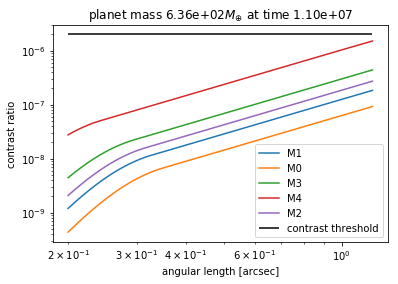

In [11]:
cr_apl_swarm, t, Mplt, star_types = swarm_apl_contrast()

visited_types = []
plt.figure(1)
for i in range(len(cr_apl_swarm)):
    if not (star_types[i] in visited_types):
        plt.loglog(a_plv/d_pl*(pc/AU), cr_apl_swarm[i],label="M"+str(star_types[i]))
        visited_types.append(star_types[i])
        
plt.hlines(contrast_thresh, a_plv[0]/d_pl *(pc/AU), a_plv[-1]/d_pl *(pc/AU), label="contrast threshold")
plt.title(r"planet mass "+"{0:.2e}".format(Mplt/Mearth)+"$M_{\oplus}$"+" at time "+"{0:.2e}".format(t))
plt.xlabel("angular length [arcsec]")
plt.ylabel("contrast ratio")
plt.legend()
plt.show()

#### Compute time vs. contrast ratio for scattered swarm light

In [14]:
def swarm_time_contrast():
    # Fix the mass of the planet at 1 M_jup
    plt_data = data_read("636")
    Mplt = 636*Mearth
    
    cr_list = []
    cr_plt_list = []
    for i in range(len(time)):
        s = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, Mplt, a_plv[0], R_pl, eta, Nstr,
                            d_pl, correction=True, alpha=1.2)

        s.updateSwarm(time[i])

        # Fix the semi-major axis at a_opt
        aopt = a_opt(time[i], s, M_s, Mplt, M0)

        B_nu_list = s.computeBmu(array([lamb]), T_star)
        F_star = Fstar(L_s, B_nu_list, T_star, d_pl)/1e-26
        
        s2 = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, Mplt,
                                aopt*AU, R_pl, eta, Nstr, d_pl,
                                rho=RHO, fQ=5, f_vrel=4/pi,
                                correction=True, alpha=1.2)

        s2.updateSwarm(time[i])
        
        # Planet Emissions
        index = plt_data.find_time_index(time[i])
        if (index > -1):
            T_plt = lum_to_temp(plt_data.lumin[index], plt_data.radii[index])
            B_nu_plt = s2.computeBmu(array([lamb]), T_plt)
            F_plt = Fstar(plt_data.lumin[index], B_nu_plt, T_plt, d_pl)
            F_plt = F_plt/1e-26
            cr_plt_list.append(F_plt/F_star)
            #print("F_plt: "+"{0:.3e}".format(F_plt[0])+"\t F_star: "+ "{0:.3e}".format(F_star[0]))
        # swarm scattered light
        contrast_swarm = contrast_scat(s2.computeAtot(), 0.32, 0.08, aopt*AU)
        cr_list.append(contrast_swarm)
    return cr_list, cr_plt_list, Mplt

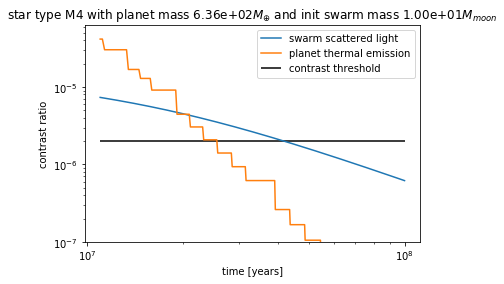

In [15]:
cr_list, cr_plt_list, Mplt = swarm_time_contrast()

plt.figure(2)
plt.loglog(time, cr_list, label="swarm scattered light")
plt.loglog(time, cr_plt_list, label="planet thermal emission")
plt.hlines(contrast_thresh, time[0], time[-1], label="contrast threshold")
plt.title(r"star type M"+str(star.subtype)+" with planet mass "+"{0:.2e}".format(Mplt/Mearth)+"$M_{\oplus}$"+
          " and init swarm mass "+"{0:.2e}".format(M0/Mmoon)+"$M_{moon}$")
plt.ylabel("contrast ratio")
plt.xlabel("time [years]")
plt.ylim(1e-7)
plt.legend()
plt.show()